# Calibration of the school model based on empirical data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import networkx as nx
import pandas as pd
import scipy as sp
from scipy.stats import lognorm
from scipy.optimize import root_scalar
from scipy.special import gamma
import numpy as np
from os.path import join

# agent based model classes & functionality
import sys
sys.path.insert(0,'../school')
sys.path.insert(0,'../nursing_home')
from model_school import SEIRX_school
import analysis_functions as af

# for progress bars
from ipywidgets import IntProgress
from IPython.display import display
import time

## Household transmissions

(0, 1.1)

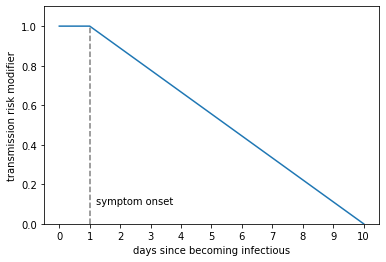

In [2]:
infection_duration = 10
exposure_duration = 5
time_until_symptoms = 6
asymptomatic_infectious = time_until_symptoms - exposure_duration

x = np.arange(0, infection_duration + 1)
def get_modifier(x):
    modifier = 1 - max(0, x - asymptomatic_infectious) / \
                (infection_duration - asymptomatic_infectious)
    return modifier
y = [get_modifier(i) for i in x]

fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot([asymptomatic_infectious, asymptomatic_infectious], [0, 1],
        '--', color='grey')
ax.text(asymptomatic_infectious + 0.2, 0.1, 'symptom onset')
ax.set_xticks(x)
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_ylabel('transmission risk modifier')
ax.set_xlabel('days since becoming infectious')
ax.set_ylim(0, 1.1)

According to a [recent meta study](https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2774102), household transmissions risk between adulty (secondary attack rate) is SAR$_\text{literature}=$ 37.8%. To calibrate the base transmission risk $r_b$ between two adults in a household, we simulate household transmissions for our setting, in which the transmission risk is declining with infection duration. Specifically, the base transmission risk is multiplied with a modifier $m(\text{day})$, which is 1 until symptom onset and then linearly decreases until it reaches zero at the time that corresponds to the infection duration (as depicted above).
1. We create two agents with epidemiological parameters (exposure time, time until symptoms, infection duration) drawn from the random distributions used for the simulation study. 
2. We define one of the two individuals as the index case and simulate a number of days equal to the infection duration of the index case. On every day, the other agent has a chance of $r_b \cdot m(\text{day})$ of becoming infected.
3. We repeat this simulation a number of times and calculate the secondary attack rate SAR$_\text{simulation}$ as the average of the number of times the second agent has become infected.

We vary $r_b$ for a range of realistic values and repeat steps 1-3. We then chose the value for $r_b$ that minimizes $|\text{SAR}_\text{literature} - \text{SAR}_\text{simulation}|$.

In [3]:
def weibull_two_param(shape, scale):
    return scale * np.random.weibull(shape)

def get_weibull_shape(k, mu, var):
    return var / mu**2 - gamma(1 + 2/k) / gamma(1+1/k)**2 + 1

def get_weibull_scale(mu, k):
    return mu / gamma(1 + 1/k)

def get_epi_params():
    # solution to the mean and variance values
    # exposure_duration = [5, 1.9]
    # time_until_symptoms = [6.4, 0.8]
    # infection_duration = [10.91, 3.95]
    epi_params = {'exposure_duration': [2.8545336526034513, 5.610922825244271],
     'time_until_symptoms': [9.602732979535194, 6.738998146675984],
     'infection_duration': [3.012881111335679, 12.215213280459125]}  

    tmp_epi_params = {}
    while True:
        for param_name, param in epi_params.items():
            tmp_epi_params[param_name] = \
                round(weibull_two_param(param[0], param[1]))

        if tmp_epi_params['exposure_duration'] > 0 and \
           tmp_epi_params['time_until_symptoms'] >= \
           tmp_epi_params['exposure_duration'] and\
           tmp_epi_params['infection_duration'] > \
           tmp_epi_params['exposure_duration']:
           return tmp_epi_params

def get_transmission_risk_time_modifier(exposure_duration, time_until_symptoms,
                                       infection_duration, days_since_exposure):
    asymptomatic_infectious = time_until_symptoms - exposure_duration
    
    try:
        modifier = 1 - max(0, days_since_exposure - asymptomatic_infectious) / \
                    (infection_duration - asymptomatic_infectious)
    except ZeroDivisionError:
        return 1
    return modifier

In [12]:
runs = range(0, 10000)
base_transmission_risks = np.arange(0.06, 0.08, 0.001)
results = pd.DataFrame()
results['transmission'] = [np.nan] * len(runs) * len(base_transmission_risks)
iterables = [base_transmission_risks, runs]
index = pd.MultiIndex.from_product(iterables, names=['base_transmission_risk', 'run'])
results.index = index

f = IntProgress(min=0, max=len(runs) * len(base_transmission_risks)) 
display(f)
c = 0

for base_transmission_risk in base_transmission_risks:
    for run in runs:
        infected = get_epi_params()
        transmission_occured = 0
        # Note: starts at day 1, to reflect the simulation implementation
        for day in range(1, infected['infection_duration'] + 1):
            modifier = get_transmission_risk_time_modifier(infected['exposure_duration'],
                    infected['time_until_symptoms'], infected['infection_duration'], day)
            modified_transmission_risk = 1 - base_transmission_risk * modifier
            transmission = np.random.random()
            if transmission > modified_transmission_risk:
                transmission_occured = 1
                break
                
        f.value = c # update the progress bar
        c += 1
            
        results.loc[base_transmission_risk, run]['transmission'] = transmission_occured

results = results.reset_index()
results_mean = results[['base_transmission_risk', 'transmission']]\
    .groupby('base_transmission_risk')\
    .agg({'transmission':['mean', 'std']})
results_mean.head(3)

IntProgress(value=0, max=210000)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



NameError: name 'results_mean' is not defined

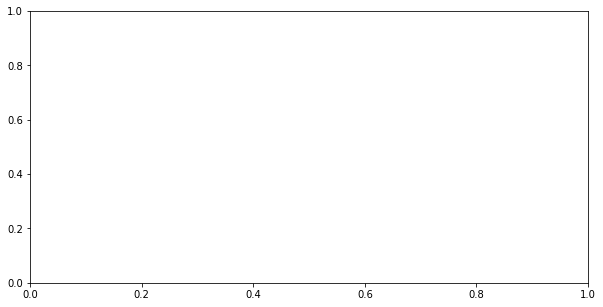

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(results_mean.index, results_mean['transmission']['mean'], 'o-', color='b')

# regression with zero intercept
x = results_mean.index.values
x = x[:, np.newaxis]
y = results_mean['transmission']['mean'].values
slope, _, _, _ = np.linalg.lstsq(x, y, rcond=None)
slope = slope[0]

ax.plot(results_mean.index, slope * results_mean.index, '--', color='k')
ax.set_xlabel('base transmission risk', fontsize=16)
ax.set_ylabel('secondary attack rate', fontsize=16)
ax.text(0.06, 0.40, 'slope: {:1.4f}'.format(slope), fontsize=16)
ax.set_title('household transmissions', fontsize=20)

target_attack_rate = 0.378
target_base_transmission_risk = float(target_attack_rate / slope)
ax.plot([0.06, 0.08],[target_attack_rate, target_attack_rate], '--', color='grey', alpha=0.5)
ax.plot([target_base_transmission_risk, target_base_transmission_risk],
        [0.25, 0.41], '--', color='grey', alpha=0.5)

ax.text(0.06, 0.25, 'base transmission risk @ attack rate 16.8%: {:1.6f}'\
        .format(target_base_transmission_risk), fontsize=14);

## Target parameters
From script ```calibration_information.ipynb```

### Outbreak sizes

Data from 2020-12-22 in file ```data/school/calibration_data/outbreak_sizes.csv```

In [4]:
def calculate_distribution_difference(school_type, ensemble_results):
    '''
    Calculates the difference between the expected distribution of outbreak
    sizes and the observed outbreak sizes in an ensemble of simulation runs
    with the same parameters. The data-frame ensemble_results holds the number
    of infected students and the number of infected teachers. NOTE: the index
    case is already subtracted from these numbers.
    '''
    # calculate the total number of follow-up cases (outbreak size)
    ensemble_results['infected_total'] = ensemble_results['infected_teachers'] +\
                    ensemble_results['infected_students']
    
    ensemble_results = ensemble_results.astype(int)
    
    # censor runs with no follow-up cases as we also do not observe these in the
    # empirical data
    ensemble_results = ensemble_results[ensemble_results['infected_total'] > 0].copy()
    observed_outbreaks = ensemble_results['infected_total'].value_counts()
    observed_outbreaks = observed_outbreaks / observed_outbreaks.sum()
    obs_dict = {size:ratio for size, ratio in zip(observed_outbreaks.index,
                                                   observed_outbreaks.values)}
    
    # since we only have aggregated data for schools with and without daycare,
    # we map the daycare school types to their corresponding non-daycare types,
    # which are also the labels of the schools in the emirical data
    type_map = {'primary':'primary', 'primary_dc':'primary',
                'lower_secondary':'lower_secondary',
                'lower_secondary_dc':'lower_secondary',
                'upper_secondary':'upper_secondary',
                'secondary':'secondary', 'secondary_dc':'secondary'}
    school_type = type_map[school_type]
    
    expected_outbreaks = pd.read_csv(\
                        '../data/school/calibration_data/outbreak_sizes.csv')
    expected_outbreaks = expected_outbreaks[\
                            expected_outbreaks['type'] == school_type].copy()
    expected_outbreaks.index = expected_outbreaks['size']
    
    exp_dict = {s:c for s, c in zip(expected_outbreaks.index, 
                                     expected_outbreaks['ratio'])}
    
    # add zeroes for both the expected and observed distributions in cases 
    # (sizes) that were not observed
    if len(observed_outbreaks) == 0:
        obs_max = 0
    else:
        obs_max = observed_outbreaks.index.max()
    
    for i in range(1, max(obs_max + 1,
                          expected_outbreaks.index.max() + 1)):
        if i not in observed_outbreaks.index:
            obs_dict[i] = 0
        if i not in expected_outbreaks.index:
            exp_dict[i] = 0
            
    obs = np.asarray([obs_dict[i] for i in range(1, len(obs_dict) + 1)])
    exp = np.asarray([exp_dict[i] for i in range(1, len(exp_dict) + 1)])
    
    chi2_distance = ((exp + 1) - (obs + 1))**2 / (exp + 1)
    chi2_distance = chi2_distance.sum()
    
    sum_of_squares = ((exp - obs)**2).sum()
    
    return chi2_distance, sum_of_squares

### Distribution of cases to agent groups

Data from 2020-12-22 in file ```data/school/calibration_data/group_distributions.csv```

In [5]:
def calculate_group_case_difference(school_type, ensemble_results):
    '''
    Calculates the difference between the expected number of infected teachers
    / infected students and the observed number of infected teachers / students
    in an ensemble of simulation runs with the same parameters. The data-frame 
    ensemble_results holds the number of infected students and the number of 
    infected teachers. NOTE: the index case is already subtracted from these
    numbers.
    '''
    
    # calculate the total number of follow-up cases (outbreak size)
    ensemble_results['infected_total'] = ensemble_results['infected_teachers'] +\
                    ensemble_results['infected_students']
    
    # censor runs with no follow-up cases as we also do not observe these in the
    # empirical data
    ensemble_results = ensemble_results[ensemble_results['infected_total'] > 0].copy()
    
    # calculate ratios of infected teachers and students
    ensemble_results['teacher_ratio'] = ensemble_results['infected_teachers'] / \
                                        ensemble_results['infected_total'] 
    ensemble_results['student_ratio'] = ensemble_results['infected_students'] / \
                                        ensemble_results['infected_total'] 
    
    observed_distro = pd.DataFrame({'group':['student', 'teacher'],
                                    'ratio':[ensemble_results['student_ratio'].mean(),
                                             ensemble_results['teacher_ratio'].mean()]})

    # since we only have aggregated data for schools with and without daycare,
    # we map the daycare school types to their corresponding non-daycare types,
    # which are also the labels of the schools in the emirical data
    type_map = {'primary':'primary', 'primary_dc':'primary',
                'lower_secondary':'lower_secondary',
                'lower_secondary_dc':'lower_secondary',
                'upper_secondary':'upper_secondary',
                'secondary':'secondary', 'secondary_dc':'secondary'}
    school_type = type_map[school_type]
    
    expected_distro = pd.read_csv(\
                        '../data/school/calibration_data/group_distributions.csv')
    expected_distro = expected_distro[\
                                expected_distro['type'] == school_type].copy()
    expected_distro.index = expected_distro['group']
    
    obs = observed_distro['ratio'].values
    exp = expected_distro['ratio'].values
    
    chi2_distance = ((exp + 1) - (obs + 1))**2 / (exp + 1)
    chi2_distance = chi2_distance.sum()
    
    sum_of_squares = ((exp - obs)**2).sum()
    
    return chi2_distance, sum_of_squares

## Calibration settings

### Index case ratios

Data from 2020-12-22

In [6]:
# empirically observed index case ratios for different school types
agent_index_ratios = {
    'primary':            {'teacher':0.939394, 'student':0.060606},
    'primary_dc':         {'teacher':0.939394, 'student':0.060606},
    'lower_secondary':    {'teacher':0.568, 'student':0.432},
    'lower_secondary_dc': {'teacher':0.568, 'student':0.432},
    'upper_secondary':    {'teacher':0.182796, 'student':0.817204},
    'secondary':          {'teacher':0.362319, 'student':0.637681},
    'secondary_dc':       {'teacher':0.362319, 'student':0.637681},
}

### Age-dependence of symptomatic courses

Data from 2020-12-22

In [7]:
# intercept: ratio of symptomatic courses for adults (at age >= 20.5)
# slope: reduction of the ratio of symptomatic courses for every year an
# agent is younger than 20.5. Values stem from a fit to empirical data of
# symptomatic courses stratified by age group (see script calibration_info.ipynb)
age_symptom_discount = {'slope':-0.02868, 'intercept':0.7954411542069012}

### Prevention measures

In [8]:
# List of prevention measures that were in place in schools in the weeks 36-45
# of the year 2020 in Austrian schools. This list was compiled from information
# collected in interviews with teachers of different school types. NOTE: so far
# there are no recorded differences between school types.
prevention_measures = {
    'primary':     
                   {'testing':'diagnostic', 
                    'follow_up_testing_interval':None,
                    'diagnostic_test_type':'one_day_PCR',
                    'preventive_screening_test_type':None,
                    'student_screen_interval':None,
                    'teacher_screen_interval':None,
                    'family_member_screen_interval':None,
                    'K1_contact_types':['intermediate', 'close'],
                    'quarantine_duration':10,
                    'half_classes':False,
                    'teacher_mask':False,
                    'student_mask':False,
                    'family_member_mask':False,
                    'student_index_probability':0,
                    'teacher_index_probability':0,
                    'family_member_index_probability':0,
                    'liberating_testing':False
                    },
    'primary_dc':     
                   {'testing':'diagnostic', 
                    'follow_up_testing_interval':None,
                    'diagnostic_test_type':'one_day_PCR',
                    'preventive_screening_test_type':None,
                    'student_screen_interval':None,
                    'teacher_screen_interval':None,
                    'family_member_screen_interval':None,
                    'K1_contact_types':['intermediate', 'close'],
                    'quarantine_duration':10,
                    'half_classes':False,
                    'teacher_mask':False,
                    'student_mask':False,
                    'family_member_mask':False,
                    'student_index_probability':0,
                    'teacher_index_probability':0,
                    'family_member_index_probability':0,
                    'liberating_testing':False
                    },
    'lower_secondary':
                   {'testing':'diagnostic', 
                    'follow_up_testing_interval':None,
                    'diagnostic_test_type':'one_day_PCR',
                    'preventive_screening_test_type':None,
                    'student_screen_interval':None,
                    'teacher_screen_interval':None,
                    'family_member_screen_interval':None,
                    'K1_contact_types':['intermediate', 'close'],
                    'quarantine_duration':10,
                    'half_classes':False,
                    'teacher_mask':False,
                    'student_mask':False,
                    'family_member_mask':False,
                    'student_index_probability':0,
                    'teacher_index_probability':0,
                    'family_member_index_probability':0,
                    'liberating_testing':False
                    },
    'lower_secondary_dc':
                   {'testing':'diagnostic', 
                    'follow_up_testing_interval':None,
                    'diagnostic_test_type':'one_day_PCR',
                    'preventive_screening_test_type':None,
                    'student_screen_interval':None,
                    'teacher_screen_interval':None,
                    'family_member_screen_interval':None,
                    'K1_contact_types':['intermediate', 'close'],
                    'quarantine_duration':10,
                    'half_classes':False,
                    'teacher_mask':False,
                    'student_mask':False,
                    'family_member_mask':False,
                    'student_index_probability':0,
                    'teacher_index_probability':0,
                    'family_member_index_probability':0,
                    'liberating_testing':False
                    },
    'upper_secondary':
                   {'testing':'diagnostic', 
                    'follow_up_testing_interval':None,
                    'diagnostic_test_type':'one_day_PCR',
                    'preventive_screening_test_type':None,
                    'student_screen_interval':None,
                    'teacher_screen_interval':None,
                    'family_member_screen_interval':None,
                    'K1_contact_types':['intermediate', 'close'],
                    'quarantine_duration':10,
                    'half_classes':False,
                    'teacher_mask':False,
                    'student_mask':False,
                    'family_member_mask':False,
                    'student_index_probability':0,
                    'teacher_index_probability':0,
                    'family_member_index_probability':0,
                    'liberating_testing':False
                    },
    'secondary':
                   {'testing':'diagnostic', 
                    'follow_up_testing_interval':None,
                    'diagnostic_test_type':'one_day_PCR',
                    'preventive_screening_test_type':None,
                    'student_screen_interval':None,
                    'teacher_screen_interval':None,
                    'family_member_screen_interval':None,
                    'K1_contact_types':['intermediate', 'close'],
                    'quarantine_duration':10,
                    'half_classes':False,
                    'teacher_mask':False,
                    'student_mask':False,
                    'family_member_mask':False,
                    'student_index_probability':0,
                    'teacher_index_probability':0,
                    'family_member_index_probability':0,
                    'liberating_testing':False
                    },
    'secondary_dc':
                   {'testing':'diagnostic', 
                    'follow_up_testing_interval':None,
                    'diagnostic_test_type':'one_day_PCR',
                    'preventive_screening_test_type':None,
                    'student_screen_interval':None,
                    'teacher_screen_interval':None,
                    'family_member_screen_interval':None,
                    'K1_contact_types':['intermediate', 'close'],
                    'quarantine_duration':10,
                    'half_classes':False,
                    'teacher_mask':False,
                    'student_mask':False,
                    'family_member_mask':False,
                    'student_index_probability':0,
                    'teacher_index_probability':0,
                    'family_member_index_probability':0,
                    'liberating_testing':False
                    },
}

### School characteristics

![title](../img/SCHULSYSTEMösterreich2.png)

In [9]:
# characteristics of the "average" school, depending on school type. These 
# characteristics were determined in interviews with Austrian teachers and from
# statistics about Austrian schools 
# (year 2017/18, page 10: https://www.bmbwf.gv.at/Themen/schule/schulsystem/gd.html)
# NOTE: "students" indicates the number of students per class

school_characteristics = {
    # Volksschule: Schulen: 3033, Klassen: 18245, Schüler*innen: 339382
    'primary':            {'classes':8, 'students':19},
    'primary_dc':         {'classes':8, 'students':19},
    
    # Hauptschulen: 47, Klassen 104, Schüler*innen: 1993
    # Neue Mittelschule: Schulen 1131, Klassen: 10354, Schüler*innen: 205905
    # Sonderschulen: 292, Klassen: 1626, Schüler*innen: 14815
    # Gesamt: Schulen: 1470, Klassen: 12084, Schüler*innen: 222713
    'lower_secondary':    {'classes':8, 'students':18},
    'lower_secondary_dc': {'classes':8, 'students':18},
    
    # Oberstufenrealgymnasium: Schulen 114, Klassen 1183, Schüler*innen: 26211
    # BMHS: schulen 734, Klassen 8042, Schüler*innen 187592
    # Gesamt: Schulen: 848, Klassen 9225, Schüler*innen: 213803
    'upper_secondary':    {'classes':10, 'students':23}, # rounded down from 10.8 classes
    
    # AHS Langform: Schulen 281, Klassen 7610, schüler*innen 179633
    'secondary':          {'classes':28, 'students':24}, # rounded up from 27.1 classes
    'secondary_dc':       {'classes':28, 'students':24} # rounded up from 27.1 classes
}

school_types = ['primary', 'primary_dc', 'lower_secondary', 'lower_secondary_dc',
                'upper_secondary', 'secondary', 'secondary_dc']

## Calibration runs

In [10]:
def compose_agents(prevention_measures):
    agent_types = {
            'student':{
                'screening_interval':prevention_measures['student_screen_interval'],
                'index_probability':prevention_measures['student_index_probability'],
                'mask':prevention_measures['student_mask']},

            'teacher':{
                'screening_interval': prevention_measures['teacher_screen_interval'],
                'index_probability': prevention_measures['student_index_probability'],
                'mask':prevention_measures['teacher_mask']},

            'family_member':{
                'screening_interval':prevention_measures['family_member_screen_interval'],
                'index_probability':prevention_measures['family_member_index_probability'],
                'mask':prevention_measures['family_member_mask']}
    }
    
    return agent_types

In [11]:
# paths for data I/O
src = '../data/school/calibration_schools'
dst = '../data/school/calibration_results'

### Set fixed parameters

In [12]:
# set the simulation parameters that are not used in this investigation to
# default values
verbosity = 0 # only needed for debug output
subclinical_modifier = 0.6 # sublinical cases are 40% less infectious than symptomatic cases
target_base_transmission_risk = 0.0737411844049918
mask_filter_efficiency  = {'exhale':0.5, 'inhale':0.7}
transmission_risk_ventilation_modifier = 0.36

### Set statistics parameters

In [13]:
## statistics parameters
# number of maximum steps per run. This is a very conservatively chosen value
# that ensures that an outbreak will always terminate within the allotted time.
# Most runs are terminated way earlier anyways, as soon as the outbreak is over.
N_steps = 500 
# number of runs per ensemble
N_runs = 100
# number of points in the parameter grid that will be randomly sampled
N_samples = 1

### Create calibration parameter grid

In [14]:
## grid of parameters that need to be calibrated
# the contact weight is the modifier by which the base transmission risk (for
# household transmissions) is multiplied for contacts of type "intermediate" 
# and of type "far"
intermediate_contact_weights = [0.5]

far_contact_weights = [0.3]

# the age_transmission_discount sets the slope of the age-dependence of the 
# transmission risk. Transmission risk for adults (age 18+) is always base 
# transmission risk. For every year an agent is younger than 18 years, the
# transmission risk is reduced
age_transmission_discounts = [-0.04]

# list of all possible parameter combinations from the grid
params = [(i, j, k) for i in intermediate_contact_weights \
                    for j in far_contact_weights\
                    for k in age_transmission_discounts if i > j]
# randomly drawn list of parameter combination indices of size N_samples. For 
# every parameter combination an ensemble of simulations will be run and 
# evaluated.

if N_samples == 'all':
    samples = range(len(params))
else:
    samples = np.random.choice(range(len(params)), N_samples, replace=False)

### Conduct calibration runs

In [20]:
school_types = ['secondary']

In [21]:
# progress bar
f = IntProgress(min=0, max=len(samples) * N_runs) 
display(f)
c = 0

results = pd.DataFrame()
for sample_index in samples:
    # get the values of the calibration parameters
    intermediate_contact_weight, far_contact_weight, age_transmission_discount = \
            params[sample_index]
    
    # since we only use contacts of type "close", "intermediate" and "far" in 
    # this setup, we set the contact type "very far" to 0. The contact type
    # "close" corresponds to household transmissions and is set to 1 (= base 
    # transmission risk). We therefore only calibrate the weight of the 
    # "intermediate"  and "far" contacts with respect to household contacts
    infection_risk_contact_type_weights = {
            'very_far': 0, 
            'far': far_contact_weight, 
            'intermediate': intermediate_contact_weight,
            'close': 1}
    
    for school_type in school_types:
        # get the respective parameters for the given school type
        measures = prevention_measures[school_type]
        characteristics = school_characteristics[school_type]
        agent_index_ratio = agent_index_ratios[school_type]

        school_name = '{}_classes-{}_students-{}'.format(school_type,
                    characteristics['classes'], characteristics['students'])
        school_src = join(src, school_type)
        
        # create the agent dictionaries based on the given parameter values and
        # prevention measures
        agent_types = compose_agents(measures)

        # conduct all runs for an ensemble with a given set of parameters
        ensemble_results = pd.DataFrame()
        for run in range(1, N_runs + 1):
            
            f.value = c # update the progress bar
            c += 1
        
            # load the contact graph: since households and sibling contacts
            # are random, there are a number of randomly created instances of 
            # calibration schools from which we can chose. We use a different
            # calibration school instance for every run here
            G = nx.readwrite.gpickle.read_gpickle(join(school_src,\
                            '{}_{}.gpickle'.format(school_name, run)))
            
            # pick an index case according to the probabilities for the school type
            index_case = np.random.choice(list(agent_index_ratio.keys()),
                                          p=list(agent_index_ratio.values()))

            # initialize the model
            model = SEIRX_school(G, verbosity, 
                      base_transmission_risk = target_base_transmission_risk,
                      testing = measures['testing'],
                      exposure_duration = [5.0, 1.9], # literature values
                      time_until_symptoms = [6.4, 0.8], # literature values
                      infection_duration = [10.91, 3.95], # literature values
                      quarantine_duration = measures['quarantine_duration'],
                      subclinical_modifier = subclinical_modifier,
                      infection_risk_contact_type_weights = \
                                 infection_risk_contact_type_weights,
                      K1_contact_types = measures['K1_contact_types'],
                      diagnostic_test_type = measures['diagnostic_test_type'],
                      preventive_screening_test_type = \
                                 measures['preventive_screening_test_type'],
                      follow_up_testing_interval = \
                                 measures['follow_up_testing_interval'],
                      liberating_testing = measures['liberating_testing'],
                      index_case = index_case,
                      agent_types = agent_types, 
                      age_transmission_risk_discount = \
                                 {'slope':age_transmission_discount, 'intercept':1},
                      age_symptom_discount = age_symptom_discount,
                      mask_filter_efficiency = mask_filter_efficiency,
                      transmission_risk_ventilation_modifier = transmission_risk_ventilation_modifier,)

            # run the model until the outbreak is over
            for i in range(N_steps):
                # break if first outbreak is over
                if len([a for a in model.schedule.agents if \
                    (a.exposed == True or a.infectious == True)]) == 0:
                    break
                model.step()

            # collect the observables needed to calculate the difference to the
            # expected values
            infected_teachers = af.count_infected(model, 'teacher')
            infected_students = af.count_infected(model, 'student')
            # subtract the index case from the number of infected teachers/students
            # to arrive at the number of follow-up cases
            if index_case == 'teacher':
                infected_teachers -= 1
            else:
                infected_students -= 1

            ensemble_results = ensemble_results.append({
                'infected_teachers':infected_teachers,
                'infected_students':infected_students}, ignore_index=True)

        # calculate the differences between the expected and observed outbreak sizes
        # and the distribution of cases to the two agent groups
        chi2_distance_size, sum_of_squares_size = \
            calculate_distribution_difference(school_type, ensemble_results)
        chi2_distance_distro, sum_of_squares_distro = \
            calculate_group_case_difference(school_type, ensemble_results)

        results = results.append({
            'school_type':school_type,
            'intermediate_contact_weight':intermediate_contact_weight,
            'far_contact_weight':far_contact_weight,
            'age_transmission_discount':age_transmission_discount,
            'chi2_distance_size':chi2_distance_size,
            'sum_of_squares_size':sum_of_squares_size,
            'chi2_distance_distro':chi2_distance_distro,
            'sum_of_squares_distro':sum_of_squares_distro,
            'chi2_distance_total':chi2_distance_size + chi2_distance_distro,
            'sum_of_squares_total':sum_of_squares_size + sum_of_squares_distro
        }, ignore_index=True)


    
#results.to_csv(join(dst, 'calibration_results_2020-12-30.csv'.format(school_type)), index=False)

IntProgress(value=0)

In [23]:
results

,age_transmission_discount,chi2_distance_distro,chi2_distance_size,chi2_distance_total,far_contact_weight,intermediate_contact_weight,school_type,sum_of_squares_distro,sum_of_squares_size,sum_of_squares_total
0,-0.04,0.0128,0.04345,0.056251,0.3,0.5,secondary,0.017967,0.045125,0.063092


## Collect calibration results

### Without ventilation

#### Random grid search

In [3]:
primary = pd.concat([\
        pd.read_csv('../data/school/calibration_results/calibration_results_primary_samples50_runs1000_random_0-50.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_primary_samples50_runs1000_random_50-100.csv')\
                       ])
primary = primary.reset_index(drop=True)

In [4]:
primary_dc = pd.concat([\
        pd.read_csv('../data/school/calibration_results/calibration_results_primary_dc_samples50_runs1000_random_0-50.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_primary_dc_samples50_runs1000_random_50-100.csv')\
                       ])
primary_dc = primary_dc.reset_index(drop=True)

In [5]:
lower_secondary = pd.concat([\
        pd.read_csv('../data/school/calibration_results/calibration_results_lower_secondary_samples50_runs1000_random_0-50.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_lower_secondary_samples50_runs1000_random_50-100.csv')\
                       ])
lower_secondary = lower_secondary.reset_index(drop=True)

In [6]:
lower_secondary_dc = pd.concat([\
        pd.read_csv('../data/school/calibration_results/calibration_results_lower_secondary_dc_samples50_runs1000_random_0-50.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_lower_secondary_dc_samples50_runs1000_random_50-100.csv')\
                       ])
lower_secondary_dc = lower_secondary_dc.reset_index(drop=True)

In [7]:
upper_secondary = pd.concat([\
        pd.read_csv('../data/school/calibration_results/calibration_results_upper_secondary_samples50_runs1000_random_0-50.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_upper_secondary_samples50_runs1000_random_50-100.csv')\
                       ])
upper_secondary = upper_secondary.reset_index(drop=True)

In [49]:
secondary = pd.concat([\
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_samples25_runs500_random_0-25.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_samples25_runs500_random_25-50.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_samples25_runs500_random_50-75.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_samples25_runs500_random_75-100.csv')\
                       ])
secondary = secondary.reset_index(drop=True)

In [94]:
secondary_dc = pd.concat([\
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_dc_samples25_runs500_random_0-25.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_dc_samples25_runs500_random_25-50.csv'),
                ])
secondary_dc = secondary.reset_index(drop=True)

In [95]:
results = pd.concat([primary[0:50], primary_dc[0:50], lower_secondary[0:50], 
                     lower_secondary_dc[0:50], upper_secondary[0:50],
                     secondary[0:50], secondary_dc[0:50]])
results = results.reset_index(drop=True)

In [96]:
# weighting by number of empirical obesrvations
outbreak_sizes = pd.read_csv('../data/school/calibration_data/outbreak_sizes.csv')
counts = pd.DataFrame({'type':['primary', 'primary_dc', 
                               'lower_secondary', 'lower_secondary_dc',
                               'upper_secondary', 'secondary', 'secondary_dc'],
                      'count':[33.5, 33.5, 90, 90, 116, 35, 35]})
counts.index = counts['type']
counts = counts.drop(columns=['type'])
counts['weight'] = counts['count'] / counts['count'].sum()

In [97]:
results['chi2_distance_total_weighted'] = results['chi2_distance_total']
weights = []
for i, row in results.iterrows():
    st = row['school_type']
    weight = counts.loc[st, 'weight']
    error = row['chi2_distance_total']
    results.loc[i, 'chi2_distance_total_weighted'] = error * weight

In [98]:
agg_results = results.groupby(['age_transmission_discount', 'intermediate_contact_weight',
                 'far_contact_weight']).sum()

In [104]:
primary = primary[0:50].groupby(['age_transmission_discount', 'intermediate_contact_weight',
                 'far_contact_weight']).sum()


In [105]:
primary_dc = primary_dc[0:50].groupby(['age_transmission_discount', 'intermediate_contact_weight',
                 'far_contact_weight']).sum()


In [106]:
lower_secondary = lower_secondary[0:50].groupby(['age_transmission_discount', 'intermediate_contact_weight',
                 'far_contact_weight']).sum()


In [107]:
lower_secondary_dc = lower_secondary_dc[0:50].groupby(['age_transmission_discount', 'intermediate_contact_weight',
                 'far_contact_weight']).sum()


In [108]:
upper_secondary = upper_secondary[0:50].groupby(['age_transmission_discount', 'intermediate_contact_weight',
                 'far_contact_weight']).sum()


In [109]:
secondary = secondary[0:50].groupby(['age_transmission_discount', 'intermediate_contact_weight',
                 'far_contact_weight']).sum()


In [110]:
secondary_dc = secondary_dc[0:50].groupby(['age_transmission_discount', 'intermediate_contact_weight',
                 'far_contact_weight']).sum()


In [111]:
primary.loc[primary['chi2_distance_total'].idxmin()]

chi2_distance_distro     0.072587
chi2_distance_size       0.005511
chi2_distance_total      0.078098
sum_of_squares_distro    0.107155
sum_of_squares_size      0.006239
sum_of_squares_total     0.113394
Name: (-0.019999999999999685, 0.42, 0.30000000000000004), dtype: float64

In [112]:
primary_dc.loc[primary_dc['chi2_distance_total'].idxmin()]

chi2_distance_distro     0.057843
chi2_distance_size       0.010876
chi2_distance_total      0.068718
sum_of_squares_distro    0.085389
sum_of_squares_size      0.012595
sum_of_squares_total     0.097984
Name: (-0.4, 0.7000000000000001, 0.68), dtype: float64

In [113]:
lower_secondary.loc[lower_secondary['chi2_distance_total'].idxmin()]

chi2_distance_distro     0.002193
chi2_distance_size       0.020126
chi2_distance_total      0.022319
sum_of_squares_distro    0.003166
sum_of_squares_size      0.026010
sum_of_squares_total     0.029176
Name: (-0.019999999999999685, 0.30000000000000004, 0.22000000000000006), dtype: float64

In [114]:
lower_secondary_dc.loc[lower_secondary_dc['chi2_distance_total'].idxmin()]

chi2_distance_distro     0.001304
chi2_distance_size       0.007455
chi2_distance_total      0.008759
sum_of_squares_distro    0.001882
sum_of_squares_size      0.009267
sum_of_squares_total     0.011149
Name: (-0.019999999999999685, 0.30000000000000004, 0.22000000000000006), dtype: float64

In [115]:
upper_secondary.loc[upper_secondary['chi2_distance_total'].idxmin()]

chi2_distance_distro     0.005901
chi2_distance_size       0.008732
chi2_distance_total      0.014633
sum_of_squares_distro    0.008256
sum_of_squares_size      0.009469
sum_of_squares_total     0.017725
Name: (-0.36, 0.28, 0.24), dtype: float64

In [116]:
secondary.loc[secondary['chi2_distance_total'].idxmin()]

chi2_distance_distro     0.000653
chi2_distance_size       0.009744
chi2_distance_total      0.010397
sum_of_squares_distro    0.000916
sum_of_squares_size      0.010117
sum_of_squares_total     0.011033
Name: (-0.2599999999999999, 0.5000000000000001, 0.3400000000000001), dtype: float64

In [103]:
secondary_dc.loc[secondary_dc['chi2_distance_total'].idxmin()]

chi2_distance_distro     0.000653
chi2_distance_size       0.009744
chi2_distance_total      0.010397
sum_of_squares_distro    0.000916
sum_of_squares_size      0.010117
sum_of_squares_total     0.011033
Name: (-0.2599999999999999, 0.5000000000000001, 0.3400000000000001), dtype: float64

In [99]:
agg_results.loc[agg_results['chi2_distance_total'].idxmin()]

chi2_distance_distro            0.209938
chi2_distance_size              0.085432
chi2_distance_total             0.295370
sum_of_squares_distro           0.306907
sum_of_squares_size             0.099981
sum_of_squares_total            0.406888
chi2_distance_total_weighted    0.034432
Name: (-0.1599999999999998, 0.3600000000000001, 0.26), dtype: float64

#### Grid search

In [118]:
primary = pd.concat([\
        pd.read_csv('../data/school/calibration_results/calibration_results_primary_samples40_runs500_grid_0-40.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_primary_samples40_runs500_grid_40-80.csv')\
                       ])
primary = primary.reset_index(drop=True)

In [119]:
primary_dc = pd.concat([\
        pd.read_csv('../data/school/calibration_results/calibration_results_primary_dc_samples40_runs500_grid_0-40.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_primary_dc_samples40_runs500_grid_40-80.csv')\
                       ])
primary_dc = primary_dc.reset_index(drop=True)

In [120]:
lower_secondary = pd.concat([\
        pd.read_csv('../data/school/calibration_results/calibration_results_lower_secondary_samples40_runs500_grid_0-40.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_lower_secondary_samples40_runs500_grid_40-80.csv')\
                       ])
lower_secondary = lower_secondary.reset_index(drop=True)

In [121]:
lower_secondary_dc = pd.concat([\
        pd.read_csv('../data/school/calibration_results/calibration_results_lower_secondary_dc_samples40_runs500_grid_0-40.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_lower_secondary_dc_samples40_runs500_grid_40-80.csv')\
                       ])
lower_secondary_dc = lower_secondary_dc.reset_index(drop=True)

In [122]:
upper_secondary = pd.concat([\
        pd.read_csv('../data/school/calibration_results/calibration_results_upper_secondary_samples40_runs500_grid_0-40.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_upper_secondary_samples40_runs500_grid_40-80.csv')\
                       ])
upper_secondary = upper_secondary.reset_index(drop=True)

In [126]:
secondary = pd.concat([\
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_samples30_runs500_grid_0-30.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_samples30_runs500_grid_30-60.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_samples20_runs500_grid_60-80.csv')\
                       ])
secondary = secondary.reset_index(drop=True)

In [128]:
secondary_dc = pd.concat([\
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_dc_samples30_runs500_grid_0-30.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_dc_samples30_runs500_grid_30-60.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_dc_samples20_runs500_grid_60-80.csv')\
                       ])
secondary_dc = secondary_dc.reset_index(drop=True)

In [129]:
results = pd.concat([primary, primary_dc, lower_secondary, 
                     lower_secondary_dc, upper_secondary,
                     secondary, secondary_dc])
results = results.reset_index(drop=True)

In [130]:
agg_results = results.groupby(['age_transmission_discount', 'intermediate_contact_weight',
                 'far_contact_weight']).sum()

In [131]:
agg_results.loc[agg_results['chi2_distance_total'].idxmin()]

chi2_distance_distro     0.151452
chi2_distance_size       0.108800
chi2_distance_total      0.260253
sum_of_squares_distro    0.220631
sum_of_squares_size      0.126304
sum_of_squares_total     0.346935
Name: (-0.03, 0.3, 0.2), dtype: float64

In [134]:
intermediate_contact_weights = [0.27, 0.28, 0.29, 0.31, 0.32, 0.33]

far_contact_weights = [0.17, 0.18, 0.19, 0.21, 0.22, 0.23]

# the age_transmission_discount sets the slope of the age-dependence of the 
# transmission risk. Transmission risk for adults (age 18+) is always base 
# transmission risk. For every year an agent is younger than 18 years, the
# transmission risk is reduced
age_transmission_discounts = [-0.032, -0.031, -0.029, -0.028]

# list of all possible parameter combinations from the grid
params = [(i, j, k) for i in intermediate_contact_weights \
                    for j in far_contact_weights\
                    for k in age_transmission_discounts if i > j]

len(params)

144

#### Fine grid search

In [137]:
primary = pd.concat([\
        pd.read_csv('../data/school/calibration_results/calibration_results_primary_samples72_runs500_fine_grid_0-72.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_primary_samples72_runs500_fine_grid_72-144.csv')\
                       ])
primary = primary.reset_index(drop=True)

In [138]:
primary_dc = pd.concat([\
        pd.read_csv('../data/school/calibration_results/calibration_results_primary_dc_samples72_runs500_fine_grid_0-72.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_primary_dc_samples72_runs500_fine_grid_72-144.csv')\
                       ])
primary_dc = primary_dc.reset_index(drop=True)

In [139]:
lower_secondary = pd.concat([\
        pd.read_csv('../data/school/calibration_results/calibration_results_lower_secondary_samples72_runs500_fine_grid_0-72.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_lower_secondary_samples72_runs500_fine_grid_72-144.csv')\
                       ])
lower_secondary = lower_secondary.reset_index(drop=True)

In [140]:
lower_secondary_dc = pd.concat([\
        pd.read_csv('../data/school/calibration_results/calibration_results_lower_secondary_dc_samples72_runs500_fine_grid_0-72.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_lower_secondary_dc_samples72_runs500_fine_grid_72-144.csv')\
                       ])
lower_secondary_dc = lower_secondary_dc.reset_index(drop=True)

In [141]:
upper_secondary = pd.concat([\
        pd.read_csv('../data/school/calibration_results/calibration_results_upper_secondary_samples36_runs500_fine_grid_0-36.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_upper_secondary_samples36_runs500_fine_grid_36-72.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_upper_secondary_samples36_runs500_fine_grid_72-108.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_upper_secondary_samples36_runs500_fine_grid_108-144.csv')\
                       ])
upper_secondary = upper_secondary.reset_index(drop=True)

In [142]:
secondary = pd.concat([\
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_samples16_runs500_fine_grid_0-16.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_samples16_runs500_fine_grid_16-32.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_samples16_runs500_fine_grid_32-48.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_samples16_runs500_fine_grid_48-64.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_samples16_runs500_fine_grid_64-80.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_samples16_runs500_fine_grid_80-96.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_samples16_runs500_fine_grid_96-112.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_samples16_runs500_fine_grid_112-128.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_samples16_runs500_fine_grid_128-144.csv')\
                       ])
secondary = secondary.reset_index(drop=True)

In [143]:
secondary_dc = pd.concat([\
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_dc_samples16_runs500_fine_grid_0-16.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_dc_samples16_runs500_fine_grid_16-32.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_dc_samples16_runs500_fine_grid_32-48.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_dc_samples16_runs500_fine_grid_48-64.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_dc_samples16_runs500_fine_grid_64-80.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_dc_samples16_runs500_fine_grid_80-96.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_dc_samples16_runs500_fine_grid_96-112.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_dc_samples16_runs500_fine_grid_112-128.csv'),
        pd.read_csv('../data/school/calibration_results/calibration_results_secondary_dc_samples16_runs500_fine_grid_128-144.csv')\
                       ])
secondary_dc = secondary_dc.reset_index(drop=True)

In [144]:
fine_results = pd.concat([primary, primary_dc, lower_secondary, 
                     lower_secondary_dc, upper_secondary,
                     secondary, secondary_dc])
fine_results = fine_results.reset_index(drop=True)

In [145]:
# weighting by number of empirical obesrvations
outbreak_sizes = pd.read_csv('../data/school/calibration_data/outbreak_sizes.csv')

In [146]:
counts = outbreak_sizes[['type', 'count']]\
    .groupby('type')\
    .sum()

In [147]:
counts = pd.DataFrame({'type':['primary', 'primary_dc', 
                               'lower_secondary', 'lower_secondary_dc',
                               'upper_secondary', 'secondary', 'secondary_dc'],
                      'count':[33.5, 33.5, 90, 90, 116, 35, 35]})
counts.index = counts['type']
counts = counts.drop(columns=['type'])
counts['weight'] = counts['count'] / counts['count'].sum()

In [148]:
fine_results['chi2_distance_total_weighted'] = fine_results['chi2_distance_total']
weights = []
for i, row in fine_results.iterrows():
    st = row['school_type']
    weight = counts.loc[st, 'weight']
    error = row['chi2_distance_total']
    fine_results.loc[i, 'chi2_distance_total_weighted'] = error * weight

In [149]:
agg_results = fine_results.groupby(['age_transmission_discount', 'intermediate_contact_weight',
                 'far_contact_weight']).sum()

In [150]:
agg_results.loc[agg_results['chi2_distance_total'].idxmin()]

chi2_distance_distro            0.157357
chi2_distance_size              0.076794
chi2_distance_total             0.234151
sum_of_squares_distro           0.229675
sum_of_squares_size             0.091339
sum_of_squares_total            0.321013
chi2_distance_total_weighted    0.026186
Name: (-0.028999999999999998, 0.32, 0.21), dtype: float64

In [226]:
agg_results.loc[agg_results['chi2_distance_total_weighted'].idxmin()]

chi2_distance_distro            0.163133
chi2_distance_size              0.097702
chi2_distance_total             0.260835
sum_of_squares_distro           0.238421
sum_of_squares_size             0.114959
sum_of_squares_total            0.353380
chi2_distance_total_weighted    0.027247
Name: (-0.04, 0.3, 0.25), dtype: float64

In [190]:
agg_results

chi2_distance_distro  \
age_transmission_discount intermediate_contact_weight far_contact_weight                         
-0.04                     0.30                        0.10                            0.228662   
                                                      0.15                            0.205456   
                                                      0.20                            0.189567   
                                                      0.25                            0.163133   
                          0.35                        0.10                            0.243367   
...                                                                                        ...   
-0.02                     0.50                        0.10                            0.264317   
                                                      0.15                            0.238219   
                                                      0.20                            0.209960   
                                                      0.25                            0.201257   
                                                      0.30                            0.211069   

                                                                          chi2_distance_size  \
age_transmission_discount intermediate_contact_weight far_contact_weight                       
-0.04                     0.30                        0.10                          0.115620   
                                                      0.15                          0.109266   
                                                      0.20                          0.100339   
                                                      0.25                          0.097702   
                          0.35                        0.10                          0.111059   
...                                                                                      ...   
-0.02                     0.50                        0.10                          0.115294   
                                                      0.15                          0.106963   
                                                      0.20                          0.111195   
                                                      0.25                          0.125675   
                                                      0.30                          0.141939   

                                                                          chi2_distance_total  \
age_transmission_discount intermediate_contact_weight far_contact_weight                        
-0.04                     0.30                        0.10                           0.344282   
                                                      0.15                           0.314722   
                                                      0.20                           0.289905   
                                                      0.25                           0.260835   
                          0.35                        0.10                           0.354425   
...                                                                                       ...   
-0.02                     0.50                        0.10                           0.379611   
                                                      0.15                           0.345182   
                                                      0.20                           0.321155   
                                                      0.25                           0.326932   
                                                      0.30                           0.353007   

                                                                          sum_of_squares_distro  \
age_transmission_discount intermediate_contact_weight far_contact_weight                          
-0.04                     0.30                        0.10                             0.3

In [189]:
agg_results['chi2_distance_total'].idxmin()

(-0.04, 0.35, 0.3)

### With ventilation

#### Random grid search

In [83]:
primary = pd.concat([\
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_primary_samples25_runs500_random_0-25.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_primary_samples25_runs500_random_25-50.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_primary_samples25_runs500_random_50-75.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_primary_samples25_runs500_random_75-100.csv') 
        ])
primary = primary.reset_index(drop=True)

In [84]:
primary_dc = pd.concat([\
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_primary_dc_samples25_runs500_random_0-25.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_primary_dc_samples25_runs500_random_25-50.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_primary_dc_samples25_runs500_random_50-75.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_primary_dc_samples25_runs500_random_75-100.csv') 
        ])
primary_dc = primary_dc.reset_index(drop=True)

In [85]:
lower_secondary = pd.concat([\
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_lower_secondary_samples25_runs500_random_0-25.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_lower_secondary_samples25_runs500_random_25-50.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_lower_secondary_samples25_runs500_random_0-25.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_lower_secondary_samples25_runs500_random_25-50.csv')
                       ])
lower_secondary = lower_secondary.reset_index(drop=True)

In [86]:
lower_secondary_dc = pd.concat([\
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_lower_secondary_dc_samples25_runs500_random_0-25.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_lower_secondary_dc_samples25_runs500_random_25-50.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_lower_secondary_dc_samples25_runs500_random_0-25.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_lower_secondary_dc_samples25_runs500_random_25-50.csv')
                       ])
lower_secondary_dc = lower_secondary_dc.reset_index(drop=True)

In [87]:
upper_secondary = pd.concat([\
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_upper_secondary_samples25_runs500_random_0-25.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_upper_secondary_samples25_runs500_random_25-50.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_upper_secondary_samples25_runs500_random_0-25.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_upper_secondary_samples25_runs500_random_25-50.csv')
                       ])
upper_secondary = upper_secondary.reset_index(drop=True)

In [88]:
secondary = pd.concat([\
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_samples10_runs500_random_0-10.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_samples10_runs500_random_10-20.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_samples10_runs500_random_20-30.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_samples10_runs500_random_30-40.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_samples10_runs500_random_40-50.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_samples10_runs500_random_50-60.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_samples10_runs500_random_60-70.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_samples10_runs500_random_70-80.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_samples10_runs500_random_80-90.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_samples10_runs500_random_90-100.csv')
                       ])
secondary = secondary.reset_index(drop=True)

In [89]:
secondary_dc = pd.concat([\
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_dc_samples10_runs500_random_0-10.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_dc_samples10_runs500_random_10-20.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_dc_samples10_runs500_random_20-30.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_dc_samples10_runs500_random_30-40.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_dc_samples10_runs500_random_40-50.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_dc_samples10_runs500_random_50-60.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_dc_samples10_runs500_random_60-70.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_dc_samples10_runs500_random_70-80.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_dc_samples10_runs500_random_80-90.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_dc_samples10_runs500_random_90-100.csv')
                       ])
secondary_dc = secondary_dc.reset_index(drop=True)

In [90]:
random_results = pd.concat([primary, primary_dc, lower_secondary, 
                     lower_secondary_dc, upper_secondary,
                     secondary, secondary_dc])
random_results = random_results.reset_index(drop=True)

In [91]:
# from ../data/school/calibration_data/outbreak_sizes.csv
counts = pd.DataFrame({'type':['primary', 'primary_dc', 
                               'lower_secondary', 'lower_secondary_dc',
                               'upper_secondary', 'secondary', 'secondary_dc'],
                      'count':[33.5, 33.5, 90, 90, 116, 35, 35]})
counts.index = counts['type']
counts = counts.drop(columns=['type'])
counts['weight'] = counts['count'] / counts['count'].sum()
random_results['chi2_distance_total_weighted'] = random_results['chi2_distance_total']
weights = []
for i, row in random_results.iterrows():
    st = row['school_type']
    weight = counts.loc[st, 'weight']
    error = row['chi2_distance_total']
    random_results.loc[i, 'chi2_distance_total_weighted'] = error * weight

In [92]:
agg_results = random_results.groupby(['age_transmission_discount', 'intermediate_contact_weight',
                 'far_contact_weight']).sum()
agg_results.loc[agg_results['chi2_distance_total_weighted'].idxmin()]

chi2_distance_distro            0.130412
chi2_distance_size              0.044697
chi2_distance_total             0.175109
sum_of_squares_distro           0.190902
sum_of_squares_size             0.048674
sum_of_squares_total            0.239576
chi2_distance_total_weighted    0.013730
Name: (-0.01999999999999999, 0.8500000000000001, 0.75), dtype: float64

#### Grid search

In [104]:
primary = pd.concat([\
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_primary_samples25_runs500_random_0-25.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_primary_samples25_runs500_random_25-50.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_primary_samples25_runs500_random_50-75.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_primary_samples25_runs500_random_75-100.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_primary_samples50_runs500_grid_0-50.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_primary_samples55_runs500_grid_50-105.csv') 
        ])
primary = primary.reset_index(drop=True)

In [105]:
primary_dc = pd.concat([\
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_primary_dc_samples50_runs500_grid_0-50.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_primary_dc_samples55_runs500_grid_50-105.csv'), 
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_primary_dc_samples25_runs500_random_0-25.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_primary_dc_samples25_runs500_random_25-50.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_primary_dc_samples25_runs500_random_50-75.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_primary_dc_samples25_runs500_random_75-100.csv') 
        ])
primary_dc = primary_dc.reset_index(drop=True)

In [106]:
lower_secondary = pd.concat([\
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_lower_secondary_samples50_runs500_grid_0-50.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_lower_secondary_samples55_runs500_grid_50-105.csv'), 
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_lower_secondary_samples25_runs500_random_0-25.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_lower_secondary_samples25_runs500_random_25-50.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_lower_secondary_samples25_runs500_random_0-25.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_lower_secondary_samples25_runs500_random_25-50.csv')
                     ])
lower_secondary = lower_secondary.reset_index(drop=True)

In [107]:
lower_secondary_dc = pd.concat([\
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_lower_secondary_dc_samples50_runs500_grid_0-50.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_lower_secondary_dc_samples50_runs500_grid_50-100.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_lower_secondary_dc_samples1_runs500_grid_100-101.csv'), 
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_lower_secondary_dc_samples1_runs500_grid_101-102.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_lower_secondary_dc_samples1_runs500_grid_102-103.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_lower_secondary_dc_samples1_runs500_grid_103-104.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_lower_secondary_dc_samples1_runs500_grid_104-105.csv'), 
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_lower_secondary_dc_samples25_runs500_random_0-25.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_lower_secondary_dc_samples25_runs500_random_25-50.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_lower_secondary_dc_samples25_runs500_random_0-25.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_lower_secondary_dc_samples25_runs500_random_25-50.csv')
                      ])
lower_secondary_dc = lower_secondary_dc.reset_index(drop=True)

In [108]:
upper_secondary = pd.concat([\
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_upper_secondary_samples25_runs500_grid_0-25.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_upper_secondary_samples25_runs500_grid_25-50.csv'), 
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_upper_secondary_samples25_runs500_grid_50-75.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_upper_secondary_samples30_runs500_grid_75-105.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_upper_secondary_samples25_runs500_random_0-25.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_upper_secondary_samples25_runs500_random_25-50.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_upper_secondary_samples25_runs500_random_0-25.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_upper_secondary_samples25_runs500_random_25-50.csv')
                                       ])
upper_secondary = upper_secondary.reset_index(drop=True)

In [109]:
secondary = pd.concat([\
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_samples10_runs500_grid_0-10.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_samples10_runs500_grid_10-20.csv'), 
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_samples10_runs500_grid_20-30.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_samples10_runs500_grid_30-40.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_samples10_runs500_grid_40-50.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_samples10_runs500_grid_50-60.csv'), 
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_samples10_runs500_grid_60-70.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_samples10_runs500_grid_70-80.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_samples10_runs500_grid_80-90.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_samples15_runs500_grid_90-105.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_samples10_runs500_random_0-10.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_samples10_runs500_random_10-20.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_samples10_runs500_random_20-30.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_samples10_runs500_random_30-40.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_samples10_runs500_random_40-50.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_samples10_runs500_random_50-60.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_samples10_runs500_random_60-70.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_samples10_runs500_random_70-80.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_samples10_runs500_random_80-90.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_samples10_runs500_random_90-100.csv')
                                    ])
secondary = secondary.reset_index(drop=True)

In [110]:
secondary_dc = pd.concat([\
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_dc_samples10_runs500_grid_0-10.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_dc_samples10_runs500_grid_10-20.csv'), 
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_dc_samples10_runs500_grid_20-30.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_dc_samples10_runs500_grid_30-40.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_dc_samples10_runs500_grid_40-50.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_dc_samples10_runs500_grid_50-60.csv'), 
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_dc_samples10_runs500_grid_60-70.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_dc_samples10_runs500_grid_70-80.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_dc_samples10_runs500_grid_80-90.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_dc_samples10_runs500_grid_90-100.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_dc_samples1_runs500_grid_100-101.csv'), 
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_dc_samples1_runs500_grid_101-102.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_dc_samples1_runs500_grid_102-103.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_dc_samples1_runs500_grid_103-104.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation_grid/calibration_results_secondary_dc_samples1_runs500_grid_104-105.csv'),                 
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_dc_samples10_runs500_random_0-10.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_dc_samples10_runs500_random_10-20.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_dc_samples10_runs500_random_20-30.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_dc_samples10_runs500_random_30-40.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_dc_samples10_runs500_random_40-50.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_dc_samples10_runs500_random_50-60.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_dc_samples10_runs500_random_60-70.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_dc_samples10_runs500_random_70-80.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_dc_samples10_runs500_random_80-90.csv'),
        pd.read_csv('../data/school/calibration_results/ventilation/calibration_results_secondary_dc_samples10_runs500_random_90-100.csv')
                                   ])
secondary_dc = secondary_dc.reset_index(drop=True)

In [111]:
grid_results = pd.concat([primary, primary_dc, lower_secondary, 
                     lower_secondary_dc, upper_secondary,
                     secondary, secondary_dc])
grid_results = grid_results.reset_index(drop=True)

In [112]:
# from ../data/school/calibration_data/outbreak_sizes.csv
counts = pd.DataFrame({'type':['primary', 'primary_dc', 
                               'lower_secondary', 'lower_secondary_dc',
                               'upper_secondary', 'secondary', 'secondary_dc'],
                      'count':[33.5, 33.5, 90, 90, 116, 35, 35]})
counts.index = counts['type']
counts = counts.drop(columns=['type'])
counts['weight'] = counts['count'] / counts['count'].sum()
grid_results['chi2_distance_total_weighted'] = grid_results['chi2_distance_total']
weights = []
for i, row in grid_results.iterrows():
    st = row['school_type']
    weight = counts.loc[st, 'weight']
    error = row['chi2_distance_total']
    grid_results.loc[i, 'chi2_distance_total_weighted'] = error * weight

In [113]:
agg_results = grid_results.groupby(['age_transmission_discount', 'intermediate_contact_weight',
                 'far_contact_weight']).sum()
agg_results.loc[agg_results['chi2_distance_total_weighted'].idxmin()]

chi2_distance_distro            0.130412
chi2_distance_size              0.044697
chi2_distance_total             0.175109
sum_of_squares_distro           0.190902
sum_of_squares_size             0.048674
sum_of_squares_total            0.239576
chi2_distance_total_weighted    0.013730
Name: (-0.01999999999999999, 0.8500000000000001, 0.75), dtype: float64

## Visualize calibration results

In [159]:
agg_results

chi2_distance_distro  \
age_transmission_discount intermediate_contact_weight far_contact_weight                         
-0.08                     0.4                         0.2                             0.212268   
                          0.6                         0.2                             0.248038   
                                                      0.4                             0.209349   
                          0.8                         0.2                             0.244821   
                                                      0.4                             0.211799   
                                                      0.6                             0.177348   
                          1.0                         0.2                             0.226159   
                                                      0.4                             0.205446   
                                                      0.6                             0.180445   
                                                      0.8                             0.164824   
-0.06                     0.4                         0.2                             0.223019   
                          0.6                         0.2                             0.226360   
                                                      0.4                             0.199857   
                          0.8                         0.2                             0.240046   
                                                      0.4                             0.205601   
                                                      0.6                             0.167012   
                          1.0                         0.2                             0.205247   
                                                      0.4                             0.187316   
                                                      0.6                             0.165848   
                                                      0.8                             0.162286   
-0.04                     0.4                         0.2                             0.212967   
                          0.6                         0.2                             0.218037   
                                                      0.4                             0.179656   
                          0.8                         0.2                             0.244308   
                                                      0.4                             0.199773   
                                                      0.6                             0.154211   
                          1.0                         0.2                             0.204282   
                                                      0.4                             0.171214   
                                                      0.6                             0.155486   
                                                      0.8                             0.143385   
-0.02                     0.4                         0.2                             0.207841   
                          0.6                         0.2                             0.235707   
                                                      0.4                             0.189876   
                          0.8                         0.2                             0.239900   
                                                      0.4                             0.192273   
                                                      0.6                             0.146454   
                          1.0                         0.2                             0.190237   
                                                      0.4                             0.165996   
                                                      0.6                             0.146460   
                                                      0.

In [172]:
nx.__version__

'2.4'

### Transmission risk splits

In [20]:
index = pd.MultiIndex.from_tuples(params, \
    names=['transmission_risk', 'age_transmission_discount', 'contact_weight'])
results.index = index

In [21]:
cases_heatmaps = {}
for tr in transmission_risks:
    img = np.zeros((len(age_transmission_discounts), len(contact_weights)))
    tr_data = results.loc[tr]
    for i, atd in enumerate(age_transmission_discounts):
        for j, cw in enumerate(contact_weights):
            img[i,j] = tr_data.loc[atd, cw]['diff_cases']
            cases_heatmaps[tr] = img

In [22]:
outbreaks_heatmaps = {}
for tr in transmission_risks:
    img = np.zeros((len(age_transmission_discounts), len(contact_weights)))
    tr_data = results.loc[tr]
    for i, atd in enumerate(age_transmission_discounts):
        for j, cw in enumerate(contact_weights):
            img[i,j] = tr_data.loc[atd, cw]['diff_outbreak_sizes_ratio']
            outbreaks_heatmaps[tr] = img

In [23]:
sum_heatmaps = {}
for tr in transmission_risks:
    img = np.zeros((len(age_transmission_discounts), len(contact_weights)))
    tr_data = results.loc[tr]
    for i, atd in enumerate(age_transmission_discounts):
        for j, cw in enumerate(contact_weights):
            img[i,j] = tr_data.loc[atd, cw]['total_diff']
            sum_heatmaps[tr] = img

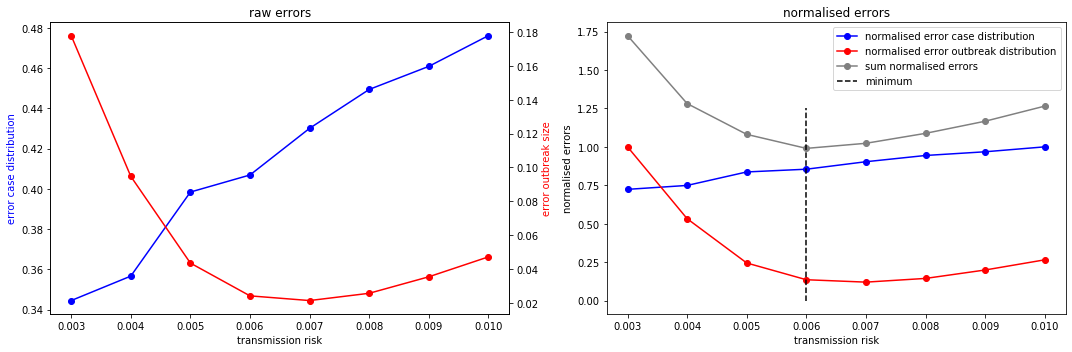

In [24]:
diff_cases = np.asarray([cases_heatmaps[tr].mean() for tr in transmission_risks])
diff_outbreaks = np.asarray([outbreaks_heatmaps[tr].mean() for tr in transmission_risks])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(transmission_risks, diff_cases, 'o-', color='b')
ax2 = axes[0].twinx()
ax2.plot(transmission_risks, diff_outbreaks, 'o-', color='r')
axes[0].set_ylabel('error case distribution', color='b')
ax2.set_ylabel('error outbreak size', color='r')
axes[0].set_xlabel('transmission risk')
axes[0].set_title('raw errors')

diff_cases_norm = diff_cases / diff_cases.max()
diff_outbreaks_norm = diff_outbreaks / diff_outbreaks.max()

axes[1].plot(transmission_risks, diff_cases_norm, 'o-', color='b', \
             label='normalised error case distribution')
axes[1].plot(transmission_risks, diff_outbreaks_norm, 'o-', color='r',
             label='normalised error outbreak distribution') 
axes[1].plot(transmission_risks, diff_cases_norm + diff_outbreaks_norm,
            'o-', color='grey', label='sum normalised errors')
axes[1].plot([0.006, 0.006], [0, 1.25], '--', color='k', label='minimum')

axes[1].legend()
axes[1].set_ylabel('normalised errors')
axes[1].set_xlabel('transmission risk')
axes[1].set_title('normalised errors')

fig.tight_layout()

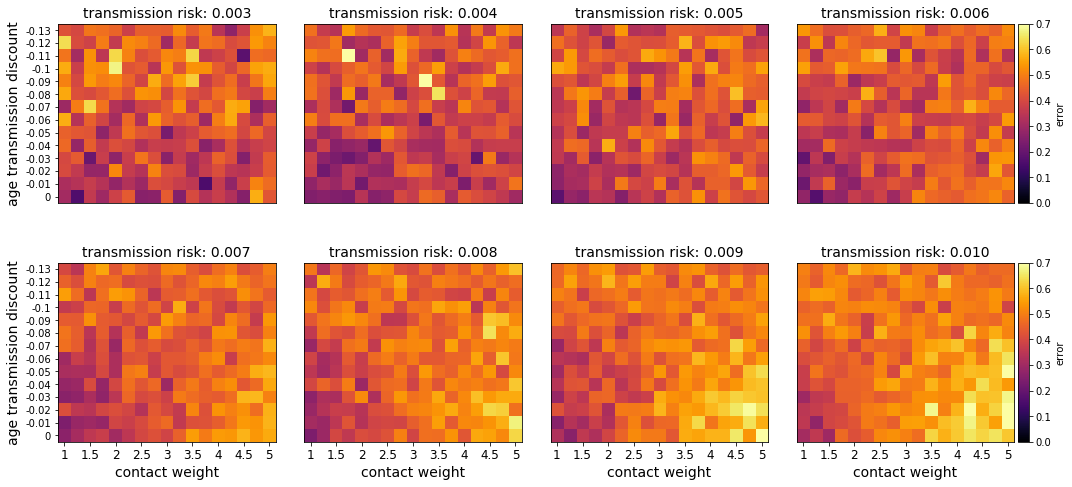

In [25]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7))
for i, ax, tr in zip(range(len(axes.flatten())), axes.flatten(), transmission_risks):
    img = ax.imshow(sum_heatmaps[tr], cmap=plt.get_cmap('inferno'), vmin=0, vmax=0.7)
    ax.set_title('transmission risk: {:1.3f}'.format(tr), fontsize=14)
    
    #ax.set_ylim(-0.5, 5.5)
    #ax.set_xlim(-0.5, 6.5)
    
    if i in [0, 4]:
        ax.set_yticks(range(len(age_transmission_discounts)))
        ax.set_yticklabels(age_transmission_discounts)
        ax.set_ylabel('age transmission discount', fontsize=14)
    else:
        ax.set_yticks([])
    
    if i in [4, 5, 6, 7]:
        ax.set_xticks(range(0,len(contact_weights), 2))
        ax.set_xticklabels(contact_weights[::2], fontsize=12)
        ax.set_xlabel('contact weight', fontsize=14)
    else:
        ax.set_xticks([])
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    if i in [3, 7]:
        fig.colorbar(img, cax=cax, orientation='vertical')
        cax.set_ylabel('error')
    else:
        cax.set_axis_off()
    

fig.tight_layout()
#plt.savefig(join(dst, '2020-12-16_calibration_results_volksschule_large_transmission_risk_range.pdf'))

### Contact weights splits

In [26]:
cases_heatmaps = {}
for cw in contact_weights:
    img = np.zeros((len(age_transmission_discounts), len(transmission_risks)))
    for i, atd in enumerate(age_transmission_discounts):
        for j, tr in enumerate(transmission_risks):
            img[i,j] = results.loc[(tr, atd, cw)]['diff_cases']
            cases_heatmaps[cw] = img

In [27]:
outbreaks_heatmaps = {}
for cw in contact_weights:
    img = np.zeros((len(age_transmission_discounts), len(transmission_risks)))
    for i, atd in enumerate(age_transmission_discounts):
        for j, tr in enumerate(transmission_risks):
            img[i,j] = results.loc[(tr, atd, cw)]['diff_outbreak_sizes']
            outbreaks_heatmaps[cw] = img

In [28]:
sum_heatmaps = {}
for cw in contact_weights:
    img = np.zeros((len(age_transmission_discounts), len(transmission_risks)))
    for i, atd in enumerate(age_transmission_discounts):
        for j, tr in enumerate(transmission_risks):
            img[i,j] = results.loc[(tr, atd, cw)]['total_diff']
            sum_heatmaps[cw] = img

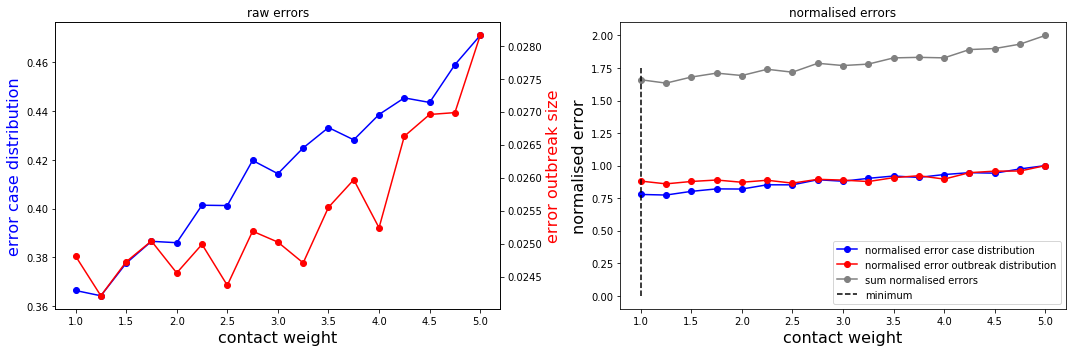

In [29]:
diff_cases = np.asarray([cases_heatmaps[cw].mean() for cw in contact_weights])
diff_outbreaks = np.asarray([outbreaks_heatmaps[cw].mean() for cw in contact_weights])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(contact_weights, diff_cases, 'o-', color='b')
ax2 = axes[0].twinx()
ax2.plot(contact_weights, diff_outbreaks, 'o-', color='r')
axes[0].set_ylabel('error case distribution', color='b', fontsize=16)
ax2.set_ylabel('error outbreak size', color='r', fontsize=16)
axes[0].set_xlabel('contact weight', fontsize=16)
axes[0].set_title('raw errors')

diff_cases_norm = diff_cases / diff_cases.max()
diff_outbreaks_norm = diff_outbreaks / diff_outbreaks.max()

axes[1].plot(contact_weights, diff_cases_norm, 'o-', color='b', \
             label='normalised error case distribution')
axes[1].plot(contact_weights, diff_outbreaks_norm, 'o-', color='r',
             label='normalised error outbreak distribution') 
axes[1].plot(contact_weights, diff_cases_norm + diff_outbreaks_norm,
            'o-', color='grey', label='sum normalised errors')
axes[1].plot([1, 1], [0, 1.75], '--', color='k', label='minimum')

axes[1].legend()
axes[1].set_xlabel('contact weight', fontsize=16)
axes[1].set_ylabel('normalised error', fontsize=16)
axes[1].set_title('normalised errors')
fig.tight_layout()

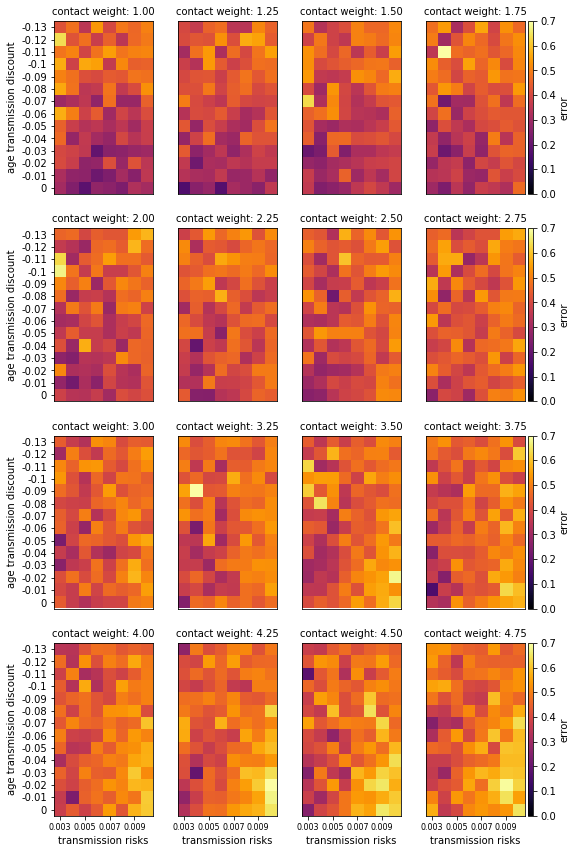

In [30]:
fig, axes = plt.subplots(4, 4, figsize=(8, 12))
for i, ax, cw in zip(range(len(axes.flatten())), axes.flatten(), contact_weights):
    img = ax.imshow(sum_heatmaps[cw], cmap=plt.get_cmap('inferno'), vmin=0, vmax=0.7)
    ax.set_title('contact weight: {:1.2f}'.format(cw), fontsize=10)
    
    #ax.set_ylim(-0.5, 5.5)
    #ax.set_xlim(-0.5, 6.5)
    
    if i in [0, 4, 8, 12]:
        ax.set_yticks(range(len(age_transmission_discounts)))
        ax.set_yticklabels(age_transmission_discounts)
        ax.set_ylabel('age transmission discount', fontsize=10)
    else:
        ax.set_yticks([])
    
    if i in [12, 13, 14, 15]:
        ax.set_xticks(range(0,len(transmission_risks),2))
        ax.set_xticklabels(transmission_risks[::2], fontsize=8)
        ax.set_xlabel('transmission risks', fontsize=10)
    else:
        ax.set_xticks([])
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    if i in [3, 7, 11, 15]:
        fig.colorbar(img, cax=cax, orientation='vertical')
        cax.set_ylabel('error')
    else:
        cax.set_axis_off()
    

fig.tight_layout()
#plt.savefig(join(dst, '2020-12-16_calibration_results_volksschule_large_transmission_risk_range.pdf'))

### Age transmission discount splits

In [31]:
cases_heatmaps = {}
for atd in age_transmission_discounts:
    img = np.zeros((len(contact_weights), len(transmission_risks)))
    for i, cw in enumerate(contact_weights):
        for j, tr in enumerate(transmission_risks):
            img[i,j] = results.loc[(tr, atd, cw)]['diff_cases']
            cases_heatmaps[atd] = img

In [32]:
outbreaks_heatmaps = {}
for atd in age_transmission_discounts:
    img = np.zeros((len(contact_weights), len(transmission_risks)))
    for i, cw in enumerate(contact_weights):
        for j, tr in enumerate(transmission_risks):
            img[i,j] = results.loc[(tr, atd, cw)]['diff_outbreak_sizes']
            outbreaks_heatmaps[atd] = img

In [33]:
sum_heatmaps = {}
for atd in age_transmission_discounts:
    img = np.zeros((len(contact_weights), len(transmission_risks)))
    for i, cw in enumerate(contact_weights):
        for j, tr in enumerate(transmission_risks):
            img[i,j] = results.loc[(tr, atd, cw)]['total_diff']
            sum_heatmaps[atd] = img

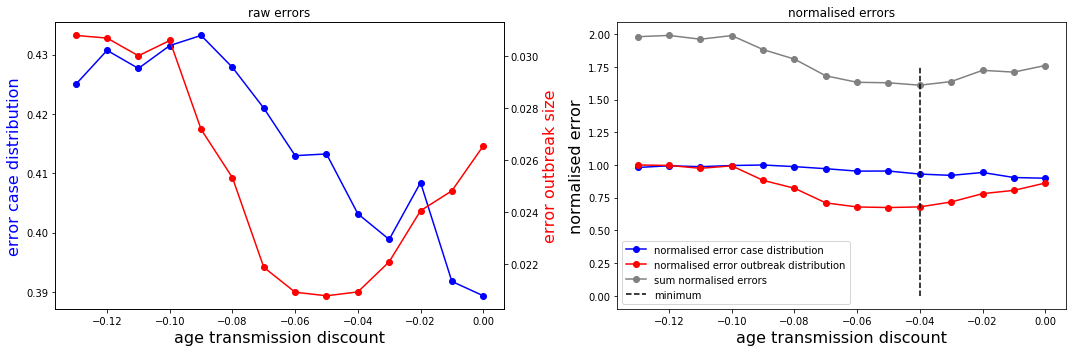

In [34]:
diff_cases = np.asarray([cases_heatmaps[atd].mean() for \
                         atd in age_transmission_discounts])
diff_outbreaks = np.asarray([outbreaks_heatmaps[atd].mean() for \
                             atd in age_transmission_discounts])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(age_transmission_discounts, diff_cases, 'o-', color='b')
ax2 = axes[0].twinx()
ax2.plot(age_transmission_discounts, diff_outbreaks, 'o-', color='r')
axes[0].set_ylabel('error case distribution', color='b', fontsize=16)
ax2.set_ylabel('error outbreak size', color='r', fontsize=16)
axes[0].set_xlabel('age transmission discount', fontsize=16)
axes[0].set_title('raw errors')

diff_cases_norm = diff_cases / diff_cases.max()
diff_outbreaks_norm = diff_outbreaks / diff_outbreaks.max()

axes[1].plot(age_transmission_discounts, diff_cases_norm, 'o-', color='b', \
             label='normalised error case distribution')
axes[1].plot(age_transmission_discounts, diff_outbreaks_norm, 'o-', color='r',
             label='normalised error outbreak distribution') 
axes[1].plot(age_transmission_discounts, diff_cases_norm + diff_outbreaks_norm,
            'o-', color='grey', label='sum normalised errors')
axes[1].plot([-0.04, -0.04], [0, 1.75], '--', color='k', label='minimum')

axes[1].legend()
axes[1].set_ylabel('normalised error', fontsize=16)
axes[1].set_xlabel('age transmission discount', fontsize=16)
axes[1].set_title('normalised errors')

fig.tight_layout()

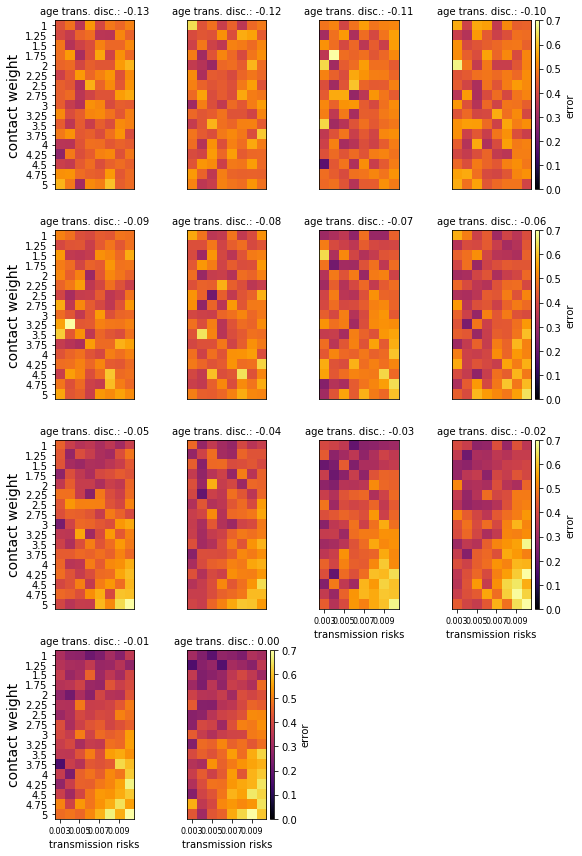

In [35]:
fig, axes = plt.subplots(4, 4, figsize=(8, 12))
for i, ax, atd in zip(range(len(axes.flatten())), axes.flatten(), age_transmission_discounts):
    img = ax.imshow(sum_heatmaps[atd], cmap=plt.get_cmap('inferno'), vmin=0, vmax=0.7)
    ax.set_title('age trans. disc.: {:1.2f}'.format(atd), fontsize=10)
    
    #ax.set_ylim(-0.5, 5.5)
    #ax.set_xlim(-0.5, 6.5)
    
    if i in [0, 4, 8, 12]:
        ax.set_yticks(range(len(contact_weights)))
        ax.set_yticklabels(contact_weights)
        ax.set_ylabel('contact weight', fontsize=14)
    else:
        ax.set_yticks([])
    
    if i in [10, 11, 12, 13]:
        ax.set_xticks(range(0, len(transmission_risks), 2))
        ax.set_xticklabels(transmission_risks[::2], fontsize=8)
        ax.set_xlabel('transmission risks', fontsize=10)
    else:
        ax.set_xticks([])
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    if i in [3, 7, 11, 13]:
        fig.colorbar(img, cax=cax, orientation='vertical')
        cax.set_ylabel('error')
    else:
        cax.set_axis_off()
    
axes[3, 2].remove()
axes[3, 3].remove()

fig.tight_layout()
#plt.savefig(join(dst, '2020-12-16_calibration_results_volksschule_large_transmission_risk_range.pdf'))

## Exemplary run

In [36]:
results['diff_cases_norm'] = results['diff_cases'] / results['diff_cases'].max()
results['diff_outreak_sizes_norm'] = results['diff_outbreak_sizes'] /\
            results['diff_outbreak_sizes'].max()

results['diff_total_norm'] = results['diff_cases_norm'] + results['diff_outreak_sizes_norm']

In [37]:
results

age_transmission_discount  \
transmission_risk age_transmission_discount contact_weight                              
0.003             -0.13                     1.00                                -0.13   
                                            1.25                                -0.13   
                                            1.50                                -0.13   
                                            1.75                                -0.13   
                                            2.00                                -0.13   
...                                                                               ...   
0.010              0.00                     4.00                                 0.00   
                                            4.25                                 0.00   
                                            4.50                                 0.00   
                                            4.75                                 0.00   
                                            5.00                                 0.00   

                                                            contact_weight  \
transmission_risk age_transmission_discount contact_weight                   
0.003             -0.13                     1.00                      1.00   
                                            1.25                      1.25   
                                            1.50                      1.50   
                                            1.75                      1.75   
                                            2.00                      2.00   
...                                                                    ...   
0.010              0.00                     4.00                      4.00   
                                            4.25                      4.25   
                                            4.50                      4.50   
                                            4.75                      4.75   
                                            5.00                      5.00   

                                                            diff_cases  \
transmission_risk age_transmission_discount contact_weight               
0.003             -0.13                     1.00              0.301813   
                                            1.25              0.314597   
                                            1.50              0.378176   
                                            1.75              0.351597   
                                            2.00              0.351175   
...                                                                ...   
0.010              0.00                     4.00              0.536633   
                                            4.25              0.567579   
                                            4.50              0.545070   
                                            4.75              0.577220   
                                            5.00              0.528761   

                                                            diff_outbreak_sizes  \
transmission_risk age_transmission_discount contact_weight                        
0.003             -0.13                     1.00                       0.119895   
                                            1.25                       0.085522   
                                            1.50                       0.108580   
                                            1.75                       0.126543   
                                            2.00                       0.106691   
...                                                                         ...   
0.010              0.00                     4.00                       0.073452   
                                            4.25                       0.083982   
                                            4.50                       0.081844   
           

In [38]:
results['diff_total_norm'].min()

0.2623057449298233

In [39]:
min_idx = results['diff_total_norm'].argmin()
opt_params = results.iloc[min_idx]

In [40]:
# progress bar
N_runs = 5000
f = IntProgress(min=0, max=N_runs) 
display(f)
c = 0

# get the values of the calibration parameters
transmission_risk = float(opt_params['transmission_risk'])
age_transmission_discount = float(opt_params['age_transmission_discount'])
contact_weight = float(opt_params['contact_weight'])

# create the agent dictionaries based on the given parameter values and
# prevention measures
agent_types = compose_agents(measures, transmission_risk, base_reception_risk)
# since we only use contacts of type "intermediate" and "far" in this setup,
# we set the contact type "far" to 1 (= base transmission risk) and only 
# calibrate the weight of the "intermediate" contacts
infection_risk_contact_type_weights = {
        'very_far': 0, 'far': 1, 'intermediate': contact_weight, 'close': 3}

# conduct all runs for an ensemble with a given set of parameters
ensemble_results = pd.DataFrame()
for run in range(N_runs):
    # pick an index case according to the probabilities for the school type
    index_case = np.random.choice(list(agent_index_ratio.keys()),
                                  p=list(agent_index_ratio.values()))

    # initialize the model
    model = SEIRX_school(G, verbosity, 
              testing = measures['testing'],
              exposure_duration = [5, 1.9], # literature values
              time_until_symptoms = [6.4, 0.8], # literature values
              infection_duration = [10.91, 3.95], # literature values
              quarantine_duration = measures['quarantine_duration'],
              subclinical_modifier = subclinical_modifier,
              infection_risk_contact_type_weights = \
                         infection_risk_contact_type_weights,
              K1_contact_types = measures['K1_contact_types'],
              diagnostic_test_type = measures['diagnostic_test_type'],
              preventive_screening_test_type = \
                         measures['preventive_screening_test_type'],
              follow_up_testing_interval = \
                         measures['follow_up_testing_interval'],
              liberating_testing = measures['liberating_testing'],
              index_case = index_case,
              agent_types = agent_types, 
              age_transmission_risk_discount = \
                         {'slope':age_transmission_discount, 'intercept':1},
              age_symptom_discount = age_symptom_discount)

    # run the model until the outbreak is over
    for i in range(N_steps):
        # break if first outbreak is over
        if len([a for a in model.schedule.agents if \
            (a.exposed == True or a.infectious == True)]) == 0:
            break
        model.step()

    # collect the observables needed to calculate the difference to the
    # expected values
    infected_teachers = af.count_infected(model, 'teacher')
    infected_students = af.count_infected(model, 'student')
    # subtract the index case from the number of infected teachers/students
    # to arrive at the number of follow-up cases
    if index_case == 'teacher':
        infected_teachers -= 1
    else:
        infected_students -= 1

    ensemble_results = ensemble_results.append({
        'infected_teachers':infected_teachers,
        'infected_students':infected_students}, ignore_index=True)

    f.value = c # update the progress bar
    c += 1


IntProgress(value=0, max=5000)

../school/agent_teacher.py:42: RuntimeWarning: invalid value encountered in double_scalars
  modifier = 1 - max(0, self.days_since_exposure - self.exposure_duration - 1) / \
../school/agent_student.py:57: RuntimeWarning: invalid value encountered in double_scalars
  modifier = 1 - max(0, self.days_since_exposure - self.exposure_duration - 1) / \


In [43]:
ensemble_results['infected_total'] = ensemble_results['infected_students'] + ensemble_results['infected_teachers']
ensemble_results = ensemble_results[ensemble_results['infected_total'] >0]\
    .reset_index(drop=True)

ensemble_results['infected_students_ratio'] = ensemble_results['infected_students'] /\
    (ensemble_results['infected_students'] + ensemble_results['infected_teachers'])

ensemble_results['infected_teachers_ratio'] = ensemble_results['infected_teachers'] /\
    (ensemble_results['infected_students'] + ensemble_results['infected_teachers'])

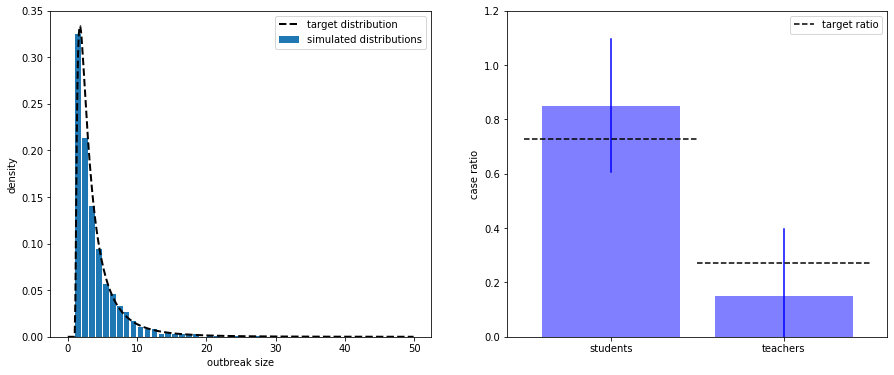

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

expected_outbreak_distro = outbreak_distro_params[school_type]
expected_agent_cases = agent_case_ratios[school_type]
lognorm_frozen = lognorm(expected_outbreak_distro['shape'],
                             scale = expected_outbreak_distro['scale'],
                             loc = expected_outbreak_distro['loc'] + 1)

axes[0].hist(ensemble_results['infected_total'], bins=range(0, 30), rwidth=0.8,
            density=True, label='simulated distributions')
x = np.arange(0, 50, 0.1)
axes[0].plot(x, lognorm_frozen.pdf(x), 'k--', lw=2, label='target distribution')
axes[0].legend()

axes[1].bar(['students', 'teachers'],[ensemble_results['infected_students_ratio'].mean(),
             ensemble_results['infected_teachers_ratio'].mean()], color='b', alpha=0.5)

axes[1].plot([0, 0], \
             [ensemble_results['infected_students_ratio'].mean() - ensemble_results['infected_students_ratio'].std(),
              ensemble_results['infected_students_ratio'].mean() + ensemble_results['infected_students_ratio'].std()],
             color='b')
axes[1].plot([1, 1], \
             [ensemble_results['infected_teachers_ratio'].mean() - ensemble_results['infected_teachers_ratio'].std(),
              ensemble_results['infected_teachers_ratio'].mean() + ensemble_results['infected_teachers_ratio'].std()],
             color='b')

axes[1].set_ylim(0, 1.2)
axes[1].plot([-0.5, 0.5], \
             [agent_case_ratios['volksschule']['student'], agent_case_ratios['volksschule']['student']],
            '--', color='k', label='target ratio')

axes[1].plot([0.5, 1.5], \
             [agent_case_ratios['volksschule']['teacher'], agent_case_ratios['volksschule']['teacher']],
            '--', color='k')

axes[0].set_xlabel('outbreak size')
axes[0].set_ylabel('density')

axes[1].set_ylabel('case ratio')
axes[1].legend()

### Convergence investigation

#### Errors

In [46]:
bootstrap_range = range(100, 1001, 10)
N_bootstrap = 100

f = IntProgress(min=0, max=len(bootstrap_range)) 
display(f)
c = 0

bs_results = pd.DataFrame()
for br in bootstrap_range:
    group_diffs = []
    outbreak_diffs = []
    infected_total = []
    for i in range(N_bootstrap):
        sample = ensemble_results.sample(br)
        sample = sample[sample['infected_total'] > 0]
        chi2_distance_size, sum_of_squares_size = \
                    calculate_distribution_difference(school_type, sample)
        chi2_distance_distro, sum_of_squares_distro = \
                    calculate_group_case_difference(school_type, sample)

        group_diffs.append(chi2_distance_distro)
        outbreak_diffs.append(chi2_distance_size)
        infected_total.append(sample['infected_total'].median())
        
    bs_results = bs_results.append({
        'samples':br,
        'group_diff_mean':np.mean(group_diffs),
        'group_diff_std':np.std(group_diffs),
        'outbreak_diff_mean':np.mean(outbreak_diffs),
        'outbreak_diff_std':np.std(outbreak_diffs),
        'total_infected_median_mean':np.mean(infected_total),
        'total_infected_median_std':np.std(infected_total),
    }, ignore_index=True)
    
    f.value = c # update the progress bar
    c += 1

IntProgress(value=0, max=91)

Text(0, 0.5, 'group distribution error')

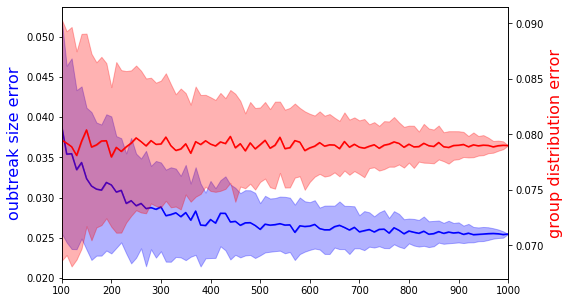

In [47]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(bs_results['samples'], bs_results['outbreak_diff_mean'], color='b')
ax.fill_between(bs_results['samples'], bs_results['outbreak_diff_mean'],
    bs_results['outbreak_diff_mean'] - bs_results['outbreak_diff_std'],
                alpha=0.3, color='b')
ax.fill_between(bs_results['samples'], bs_results['outbreak_diff_mean'],
    bs_results['outbreak_diff_mean'] + bs_results['outbreak_diff_std'],
                alpha=0.3, color='b')

ax2 = ax.twinx()
ax2.plot(bs_results['samples'], bs_results['group_diff_mean'], color='r')
ax2.fill_between(bs_results['samples'], bs_results['group_diff_mean'],
    bs_results['group_diff_mean'] - bs_results['group_diff_std'],
                alpha=0.3, color='r')
ax2.fill_between(bs_results['samples'], bs_results['group_diff_mean'],
    bs_results['group_diff_mean'] + bs_results['group_diff_std'],
                alpha=0.3, color='r')

ax.set_xlim(100, 1000)
ax.set_ylabel('oubtreak size error', color='b', fontsize=16)
ax2.set_ylabel('group distribution error', color='r', fontsize=16)

#### Medians

Text(0, 0.5, 'oubtreak size median')

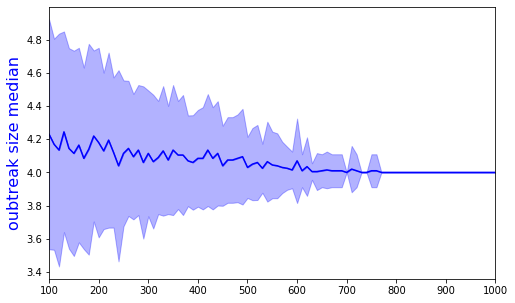

In [48]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(bs_results['samples'], bs_results['total_infected_median_mean'], color='b')
ax.fill_between(bs_results['samples'], bs_results['total_infected_median_mean'],
    bs_results['total_infected_median_mean'] - bs_results['total_infected_median_std'],
                alpha=0.3, color='b')
ax.fill_between(bs_results['samples'], bs_results['total_infected_median_mean'],
    bs_results['total_infected_median_mean'] + bs_results['total_infected_median_std'],
                alpha=0.3, color='b')

ax.set_xlim(100, 1000)
ax.set_ylabel('oubtreak size median', color='b', fontsize=16)

## Code graveyard

In [3]:
def calculate_distribution_difference(expected_outbreak_distro, ensemble_results):
    '''
    Calculates the difference between the expected distribution of outbreak
    sizes and the observed outbreak sizes in an ensemble of simulation runs
    with the same parameters. The data-frame ensemble_results holds the number
    of infected students and the number of infected teachers. NOTE: the index
    case is already subtracted from these numbers.
    '''
    # calculate the total number of follow-up cases (outbreak size)
    ensemble_results['infected_total'] = ensemble_results['infected_teachers'] +\
                    ensemble_results['infected_students']
    
    # censor runs with no follow-up cases as we also do not observe these in the
    # empirical data
    ensemble_results = ensemble_results[ensemble_results['infected_total'] > 0]
    
    # get the lognomal distribution with the given parameters of the expected
    # distribution
    lognorm_frozen = lognorm(expected_outbreak_distro['shape'],
                             scale = expected_outbreak_distro['scale'],
                             loc = expected_outbreak_distro['loc'])
    
    # outbreak size ratios in all outbreak sizes
    y = ensemble_results['infected_total'].value_counts().values / \
        len(ensemble_results) 
    # outbreak sizes
    x = ensemble_results['infected_total'].value_counts().index 
    
    # calculate the difference between the observed outbreak sizes and the
    # distribution of expected outbreak sizes 
    diff_outbreak_sizes_squares = ((lognorm_frozen.pdf(x) - y)**2).sum()
    diff_outbreak_sizes_relative = \
        np.abs((lognorn_frozen.pdf(x) - y) / lognorn_frozen.pdf(x)).sum()
    
    return diff_outbreak_sizes_squares, diff_outbreak_sizes_relative

In [5]:
def calculate_group_case_difference(expected_agent_cases, ensemble_results):
    '''
    Calculates the difference between the expected number of infected teachers
    / infected students and the observed number of infected teachers / students
    in an ensemble of simulation runs with the same parameters. The data-frame 
    ensemble_results holds the number of infected students and the number of 
    infected teachers. NOTE: the index case is already subtracted from these
    numbers.
    '''
    # calculate ratios of infected teachers and students
    ensemble_results['teacher_ratio'] = ensemble_results['infected_teachers'] / \
        (ensemble_results['infected_teachers'] + ensemble_results['infected_students'])
    ensemble_results['student_ratio'] = ensemble_results['infected_students'] / \
        (ensemble_results['infected_teachers'] + ensemble_results['infected_students'])
    
    # censor runs with no follow-up cases as we also do not observe these in the
    # empirical data
    ensemble_results = ensemble_results[\
                        (ensemble_results['infected_students'] > 0) | \
                        (ensemble_results['infected_teachers'] > 0)]
    
    expected_teacher_cases = expected_agent_cases['teacher']
    expected_student_cases = expected_agent_cases['student']
    # calculate the observed cases as ensemble means
    observed_teacher_cases = ensemble_results['teacher_ratio'].mean()
    observed_student_cases = ensemble_results['student_ratio'].mean()
    
    diff_cases = (expected_teacher_cases - observed_teacher_cases)**2 + \
                 (expected_student_cases - observed_student_cases)**2
    
    # the weighing by a factor of 10 is an empirical factor to make sure the
    # difference from the agent group distribution is of the same order of
    # magnitude as the difference from the outbreak distribution and therefore
    # the total difference is not predominantly driven by either of the two
    # contributions.
    return diff_cases * 10